In [1]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import src.embeddings as emb
import src.similarity as sim
import src.metrics as met
import src.utils as utils

/Users/erikluu/Documents/Poly/Thesis/LociNet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Thesis Evaluation

## Helper Functions

In [2]:
def load_data(filepath, n=None):
    assert filepath[-4:] == ".csv", "Must be a .csv file"
    data = pd.read_csv(filepath)
    if n:
        data = data.head(n)

    attrs = {
        "titles": data["title"].tolist(),
        "text": data["text"].tolist(),
        "tags": data["tags"].apply(ast.literal_eval).tolist(),
        "ids": data.index.tolist()
    }

    if "simplified_tags" in data.columns:
        attrs["simplified_tags"] = data["simplified_tags"].apply(ast.literal_eval).tolist()

    return attrs

In [3]:
def visualize_embeddings_comparisons(dataframes: list[pd.DataFrame]):
    """
    Visualizes comparisons between all nodes and shared tags for multiple dataframes.

    Args:
        dataframes (List[pd.DataFrame]): A list of dataframes to be combined and visualized.
    """
    # Combine the dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Melt the dataframe to have 'between_all_nodes' and 'between_shared_tags' in a single column
    melted_df = combined_df.melt(id_vars=['data_source', 'embedding_model', 'metric_name', 'metric'], 
                                 value_vars=['between_all_nodes', 'between_shared_tags'], 
                                 var_name='comparison_type', value_name='value')

    # Set up the matplotlib figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 18))

    # Bar plot for mean, median, std_dev comparison
    sns.barplot(data=melted_df[melted_df['metric'] == 'mean'], x='metric_name', y='value', hue='comparison_type', errorbar=None, ax=axes[0])
    axes[0].set_title('Mean Comparison Between All Nodes and Shared Tags')
    axes[0].set_xlabel('Metric Name')
    axes[0].set_ylabel('Value')
    axes[0].legend(title='Comparison Type')

    sns.barplot(data=melted_df[melted_df['metric'] == 'median'], x='metric_name', y='value', hue='comparison_type', errorbar=None, ax=axes[1])
    axes[1].set_title('Median Comparison Between All Nodes and Shared Tags')
    axes[1].set_xlabel('Metric Name')
    axes[1].set_ylabel('Value')
    axes[1].legend(title='Comparison Type')

    sns.barplot(data=melted_df[melted_df['metric'] == 'std_dev'], x='metric_name', y='value', hue='comparison_type', errorbar=None, ax=axes[2])
    axes[2].set_title('Standard Deviation Comparison Between All Nodes and Shared Tags')
    axes[2].set_xlabel('Metric Name')
    axes[2].set_ylabel('Value')
    axes[2].legend(title='Comparison Type')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    # Create separate plots for each embedding model for clarity
    for model in combined_df['embedding_model'].unique():
        model_df = melted_df[melted_df['embedding_model'] == model]
        
        # Line plot for each model
        plt.figure(figsize=(14, 8))
        sns.lineplot(data=model_df, x='metric_name', y='value', hue='comparison_type', style='metric', markers=True, errorbar=None)
        plt.title(f'Metric Trends Comparison for {model}')
        plt.xlabel('Metric Name')
        plt.ylabel('Value')
        plt.legend(title='Comparison Type')
        plt.show()

## Data: interview_prep.csv

In [4]:
data_name = "interview_prep"
data = load_data(f"data/{data_name}.csv")

### sentence-transformers/all-MiniLM-L6-v2

In [5]:
model_name = "minilm"
embeddings = emb.process_embeddings(data["text"], model_name)
cosine_sim, soft_cosine_sim, euclidean_sim = sim.get_all_similarities(embeddings)
all_mini_df = met.calculate_embedding_metrics_for_all(cosine_sim, soft_cosine_sim, euclidean_sim,
                                        data["tags"], model_name, data_name)

Initializing sentence-transformers/all-MiniLM-L6-v2 Model


Calculating euclidean similarities: 100%|██████████| 1/1 [00:00<00:00, 304.22it/s]


### nomic-ai/nomic-embed-text-v1.5 

In [7]:
model_name = "nomic"
embeddings = emb.process_embeddings(data["text"], model_name)
cosine_sim, soft_cosine_sim, euclidean_sim = sim.get_all_similarities(embeddings)
nomic_df = met.calculate_embedding_metrics_for_all(cosine_sim, soft_cosine_sim, euclidean_sim,
                                        data["tags"], model_name, data_name)

Initializing Nomic Model


<All keys matched successfully>
Calculating euclidean similarities: 100%|██████████| 1/1 [00:00<00:00, 1842.03it/s]


### google/bert_uncased_L-12_H-768_A-12

In [89]:
model_name = "bert"
embeddings = emb.process_embeddings(data["text"], model_name)
cosine_sim, soft_cosine_sim, euclidean_sim = sim.get_all_similarities(embeddings)
bert_df = met.calculate_embedding_metrics_for_all(cosine_sim, soft_cosine_sim, euclidean_sim,
                                        data["tags"], model_name, data_name)

Initializing Google BERT Model


/Users/erikluu/Documents/Poly/Thesis/LociNet/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Calculating euclidean similarities: 100%|██████████| 1/1 [00:00<00:00, 911.61it/s]


### visualize

In [ ]:
combined_df = pd.concat([all_mini_df, nomic_df], ignore_index=True)
melted_df = combined_df.melt(id_vars=['data_source', 'embedding_model', 'metric_name', 'metric'], 
                             value_vars=['between_all_nodes', 'between_shared_tags'], 
                             var_name='comparison_type', value_name='value')

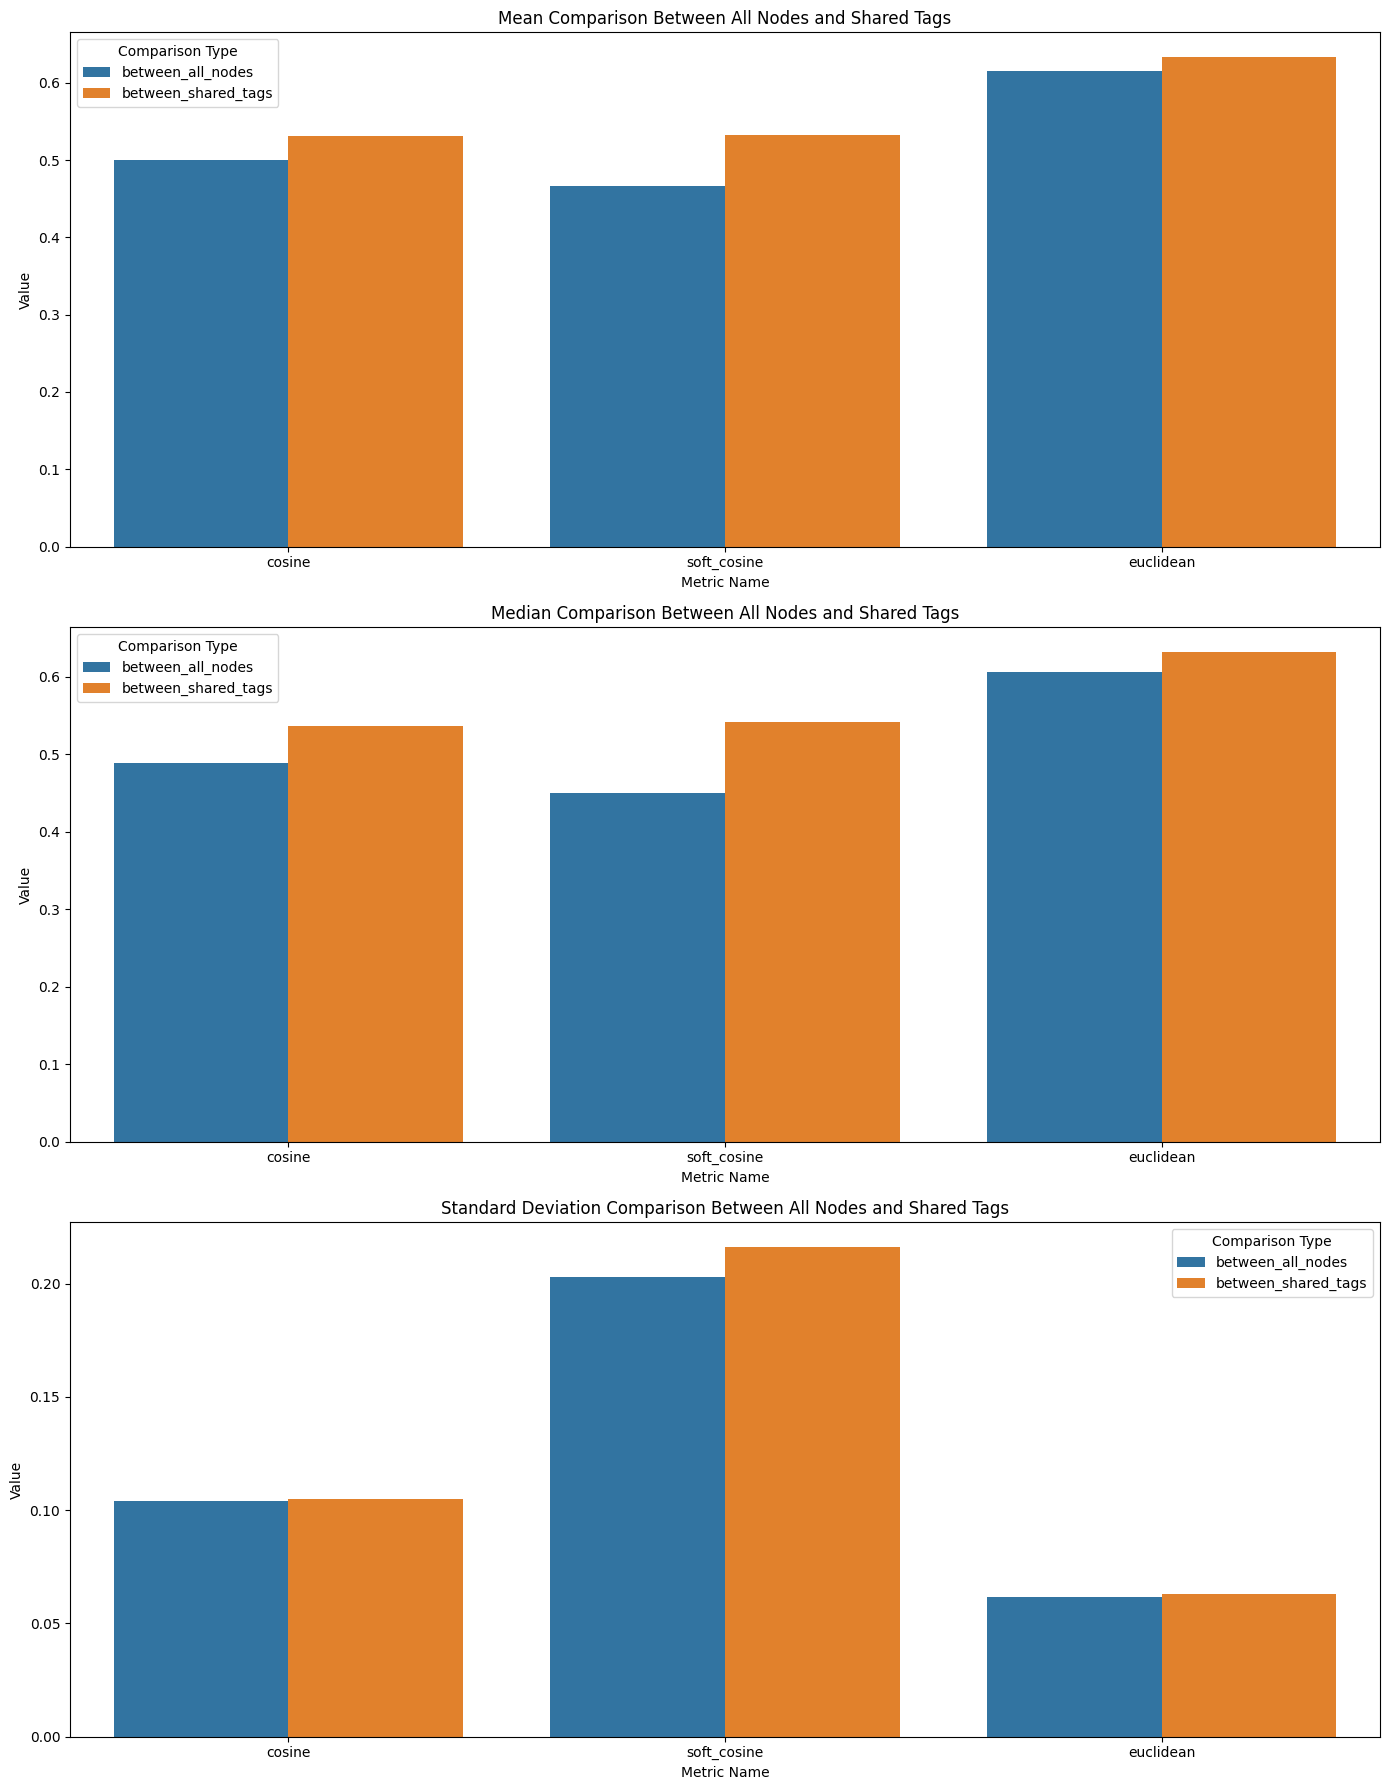

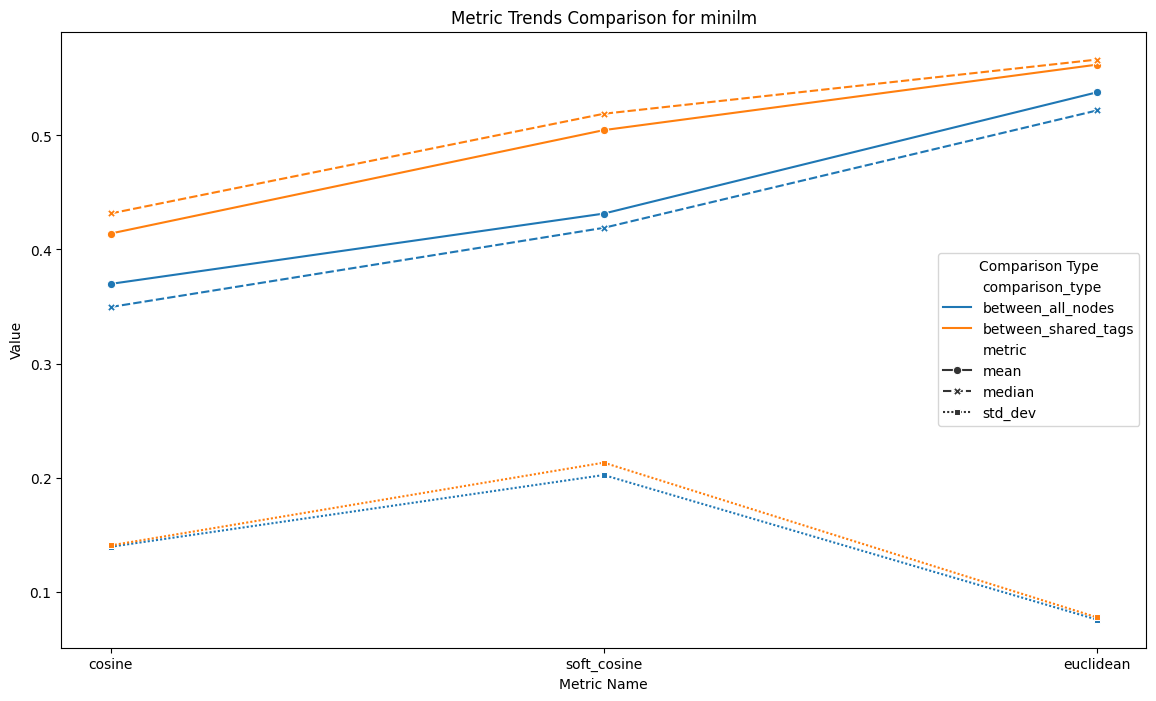

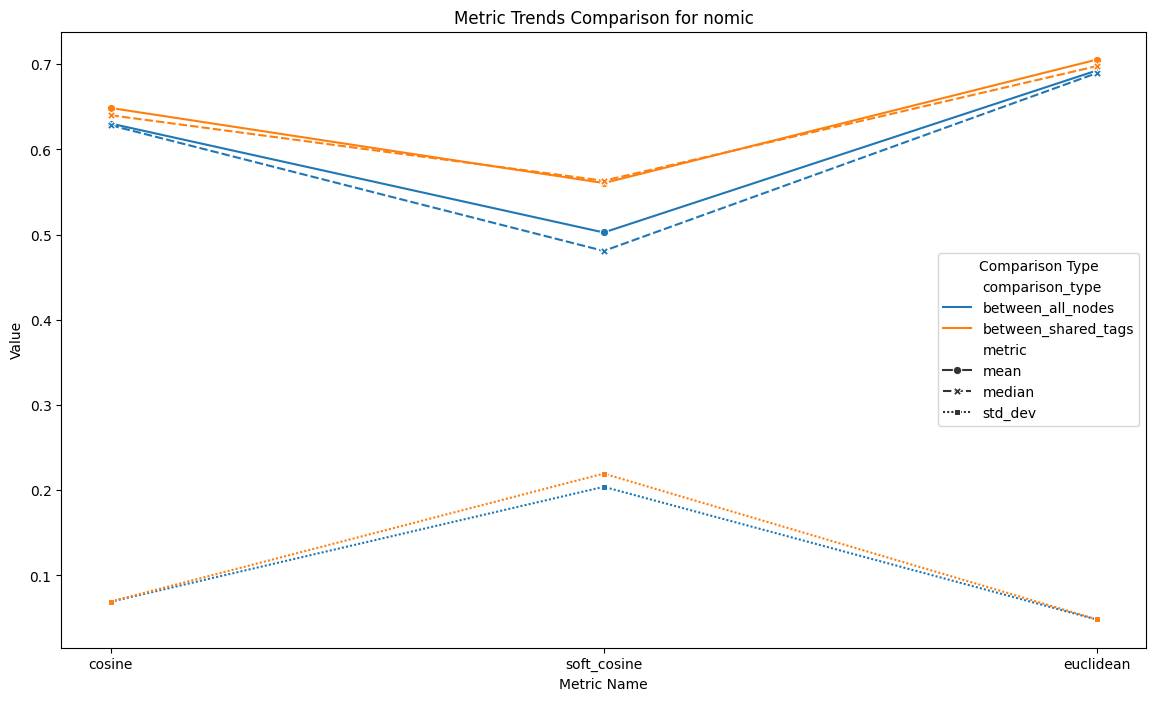

In [8]:
visualize_embeddings_comparisons([all_mini_df, nomic_df])

## Data: Medium (n=1000)

In [ ]:
minilm_embeddings = utils.load_from_pickle("embeddings/medium1k_minilm_n10000.pickle")
minilm_cosine_sim, minilm_soft_cosine_sim, minilm_euclidean_sim = sim.get_all_similarities(minilm_embeddings)

mpnet_embeddings = utils.load_from_pickle(f"embeddings/medium1k_mpnet_n10000.pickle")
mpnet_cosine_sim, mpnet_soft_cosine_sim, mpnet_euclidean_sim = sim.get_all_similarities(mpnet_embeddings)

nomic_embeddings = utils.load_from_pickle(f"embeddings/medium1k_nomic_n10000.pickle")
nomic_cosine_sim, nomic_soft_cosine_sim, nomic_euclidean_sim = sim.get_all_similarities(nomic_embeddings)

bert_embeddings = utils.load_from_pickle(f"embeddings/medium1k_bert_n10000.pickle")
bert_cosine_sim, bert_soft_cosine_sim, bert_euclidean_sim = sim.get_all_similarities(bert_embeddings)

specter_embeddings = utils.load_from_pickle(f"embeddings/medium1k_specter_n10000.pickle")
specter_cosine_sim, specter_soft_cosine_sim, specter_euclidean_sim = sim.get_all_similarities(specter_embeddings)

Calculating cosine similarities:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating euclidean similarities: 100%|██████████| 40/40 [00:04<00:00,  8.27it/s]


In [ ]:
all_minilm_df = met.calculate_embedding_metrics_for_all(minilm_cosine_sim, minilm_soft_cosine_sim, minilm_euclidean_sim,
                                        tags, "minilm", data_name)
all_mpnet_df = met.calculate_embedding_metrics_for_all(mpnet_cosine_sim, mpnet_soft_cosine_sim, mpnet_euclidean_sim,
                                        tags, "mpnet", data_name)
nomic_df = met.calculate_embedding_metrics_for_all(nomic_cosine_sim, nomic_soft_cosine_sim, nomic_euclidean_sim,
                                        tags, "nomic", data_name)
bert_df = met.calculate_embedding_metrics_for_all(bert_cosine_sim, bert_soft_cosine_sim, bert_euclidean_sim,
                                        tags, "bert", data_name)
specter_df = met.calculate_embedding_metrics_for_all(specter_cosine_sim, specter_soft_cosine_sim, specter_euclidean_sim,
                                        tags, "specter", data_name)

In [ ]:
combined_df = pd.concat([all_minilm_df, nomic_df, all_mpnet_df, bert_df, specter_df], ignore_index=True)
melted_df = combined_df.melt(id_vars=['data_source', 'embedding_model', 'metric_name', 'metric'], 
                             value_vars=['between_all_nodes', 'between_shared_tags'], 
                             var_name='comparison_type', value_name='value')

In [ ]:
melted_df[melted_df["metric_name"] == "euclidean"]

,data_source,embedding_model,metric_name,metric,comparison_type,value
6,medium_1k_tags_simplified,minilm,euclidean,mean,between_all_nodes,-1.289688
7,medium_1k_tags_simplified,minilm,euclidean,median,between_all_nodes,-1.312505
8,medium_1k_tags_simplified,minilm,euclidean,std_dev,between_all_nodes,0.111180
15,medium_1k_tags_simplified,nomic,euclidean,mean,between_all_nodes,-0.948111
16,medium_1k_tags_simplified,nomic,euclidean,median,between_all_nodes,-0.955805
17,medium_1k_tags_simplified,nomic,euclidean,std_dev,between_all_nodes,0.088361
24,medium_1k_tags_simplified,mpnet,euclidean,mean,between_all_nodes,-1.317367
25,medium_1k_tags_simplified,mpnet,euclidean,median,between_all_nodes,-1.339194
26,medium_1k_tags_simplified,mpnet,euclidean,std_dev,between_all_nodes,0.095820
33,medium_1k_tags_simplified,bert,euclidean,mean,between_all_nodes,-0.542960


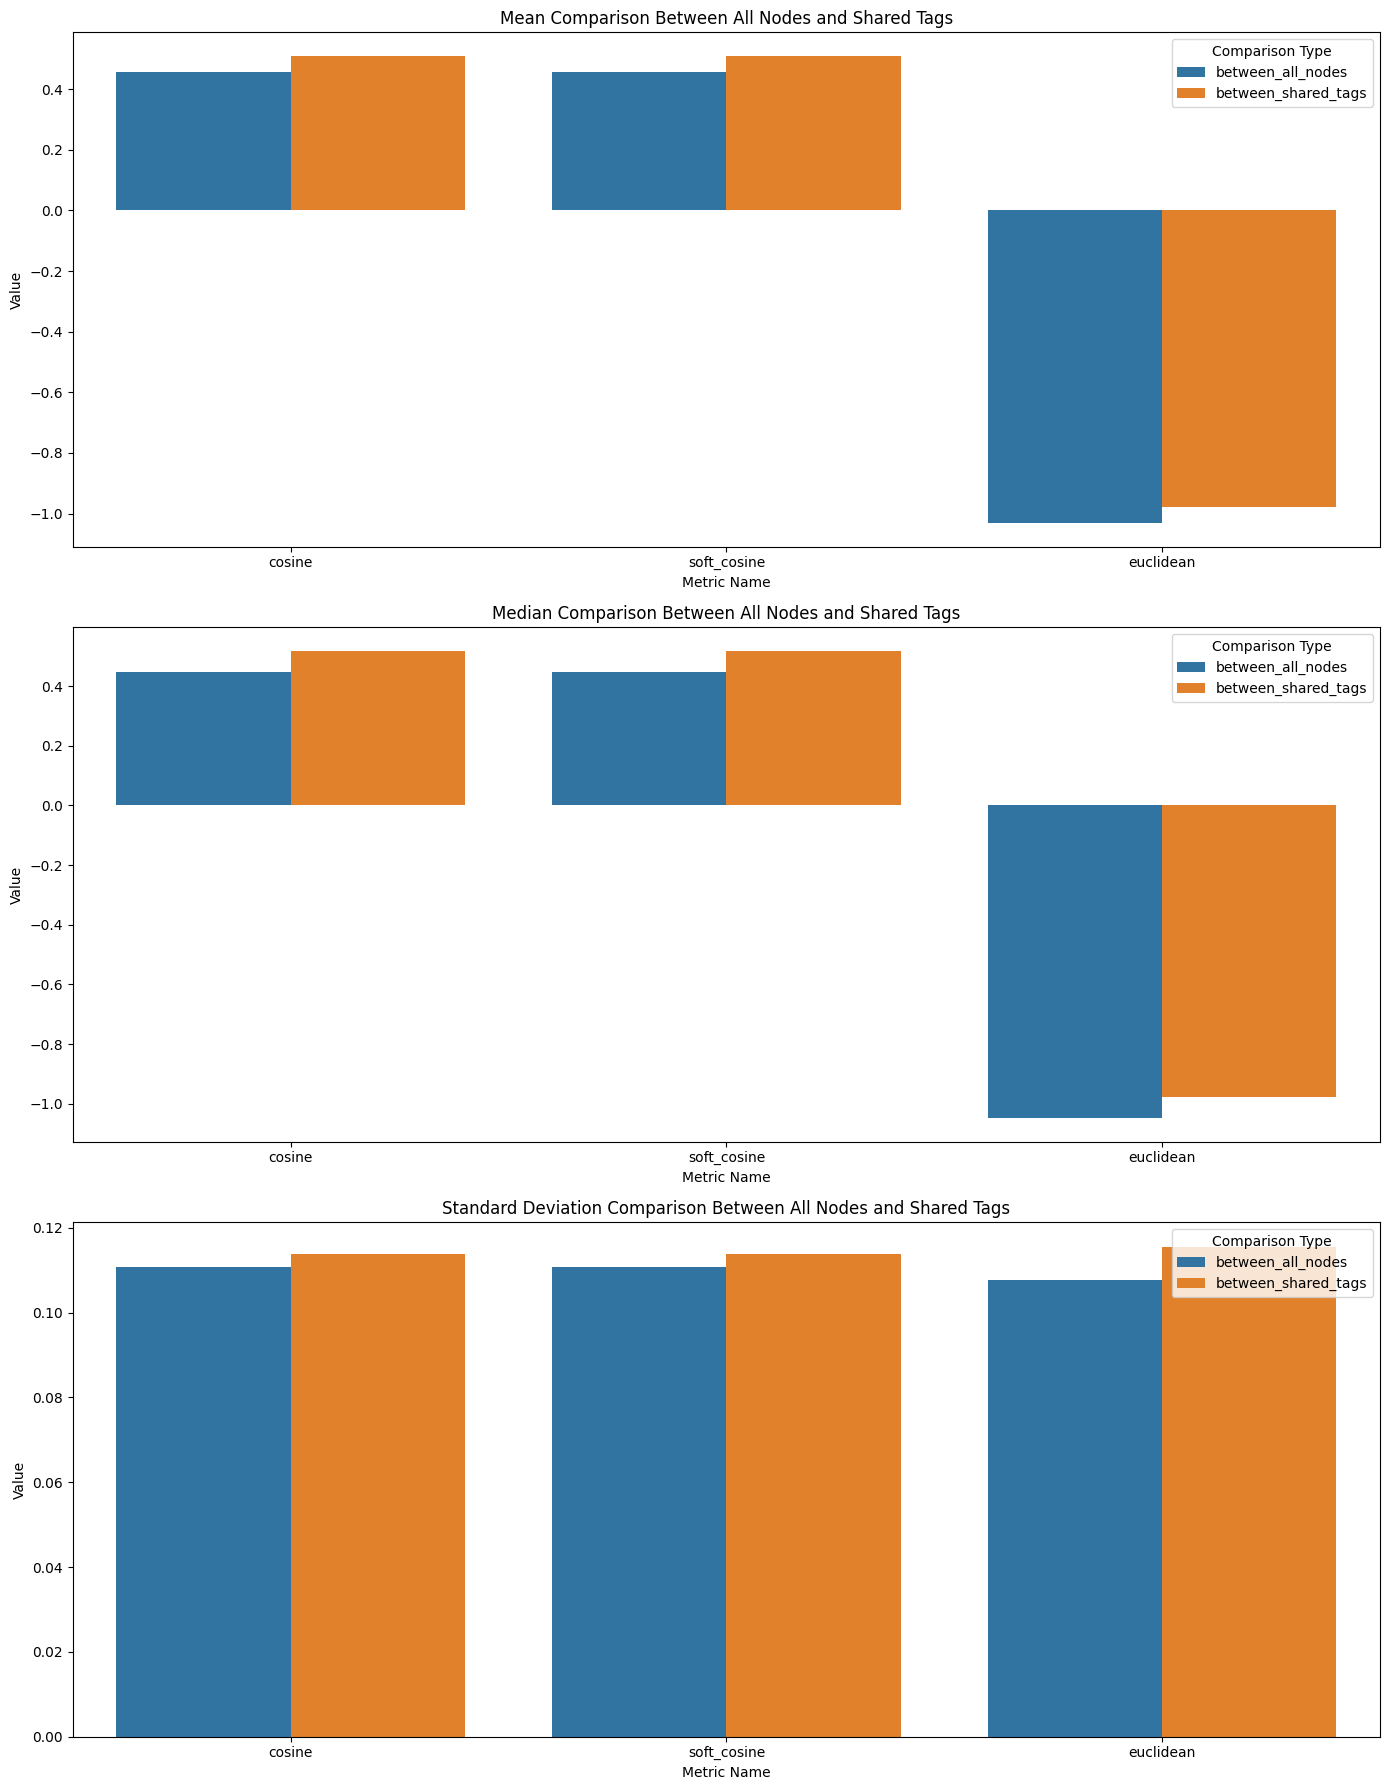

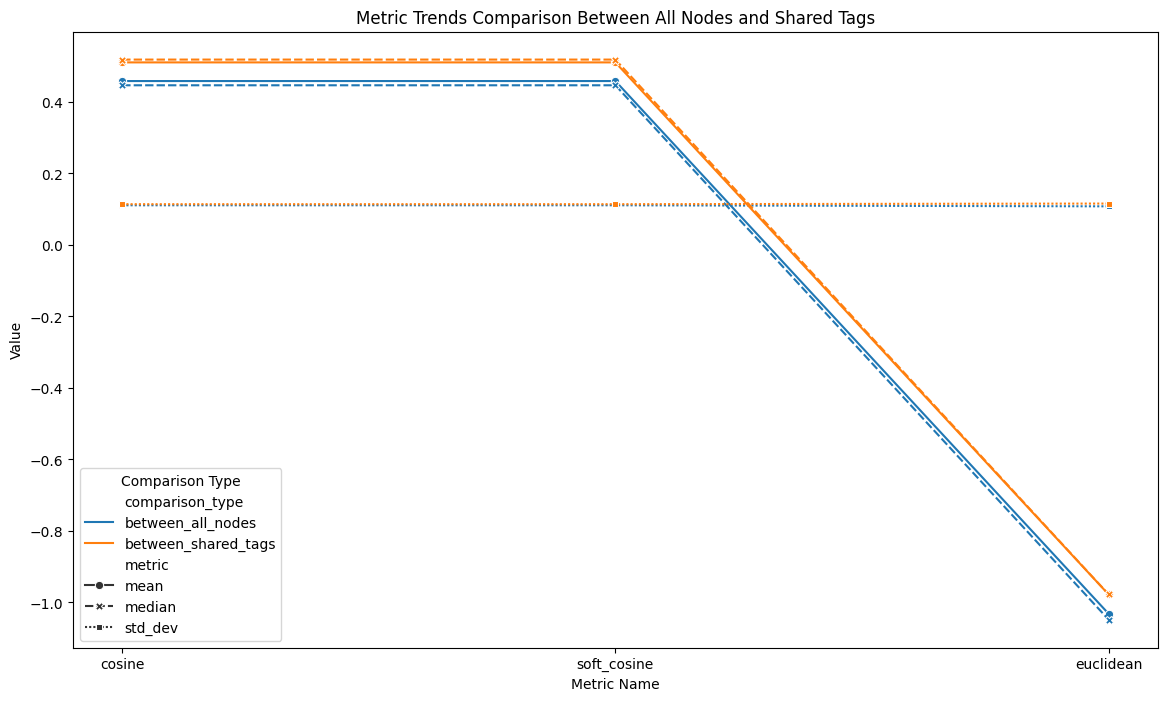

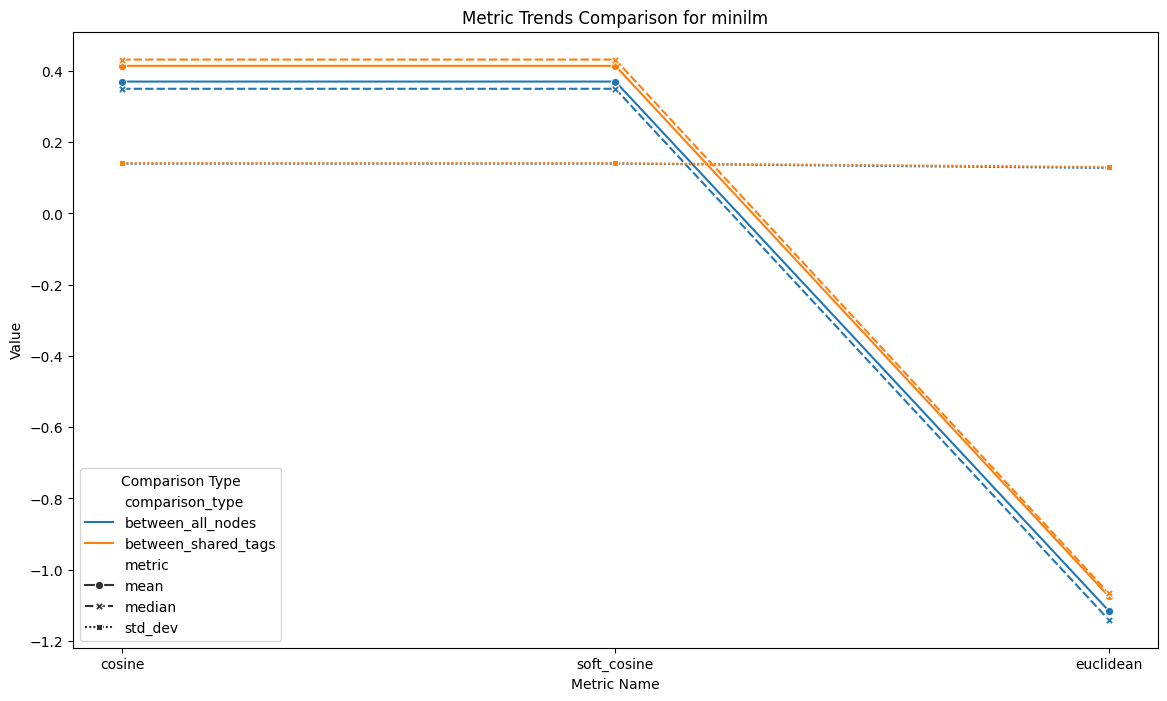

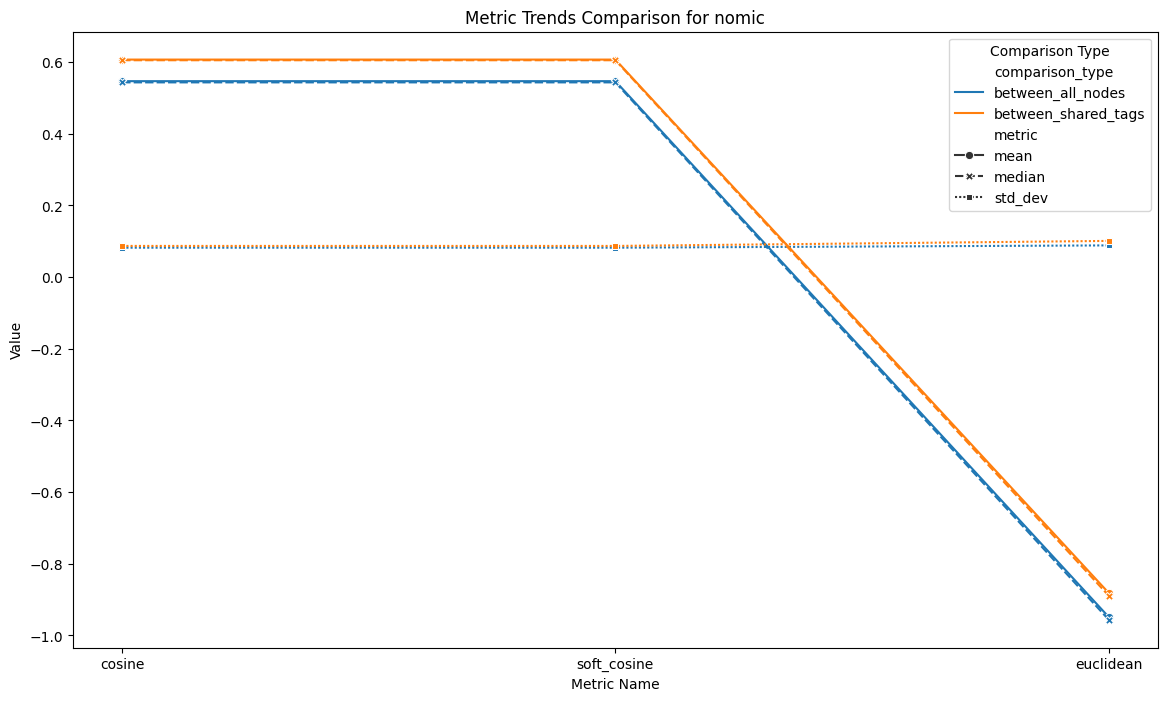

In [ ]:
visualize_embeddings_comparisons([all_mini_df, nomic_df])